In [0]:
# import package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
from sklearn.metrics import mean_squared_error

In [0]:
# Upload the data
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving MyData.csv to MyData.csv
User uploaded file "MyData.csv" with length 5291697 bytes


In [0]:
dataset = pd.read_csv('MyData.csv')
# Set test data and training data
dataset.index=dataset.Date
test = dataset.loc['2017-01-03':'2017-12-29']
train = dataset.loc['2009-01-05':'2016-12-30']
training_set=train.iloc[:,2].values.reshape(-1,1)
print(training_set)
type(training_set)

[[ 13.511429]
 [ 13.288571]
 [ 13.001429]
 ...
 [116.76    ]
 [116.73    ]
 [115.82    ]]


numpy.ndarray

In [0]:
#Feature Scaling
sc = MinMaxScaler(feature_range= (0,1))
#It is going to fit the training_set and transforms the data.
scaled_training_set = sc.fit_transform(training_set)

#Creating the data structure with 60 timesteps and 1 output 
#In each time 't' , RNN will look 60 timesteps (days) before steps to predict the next output
X_train = []
y_train = []
for i in range(60, 2013):
    X_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
 
#Reshaping for giving X_train to the RNN as an input.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1953, 60, 1)


In [0]:
#Part - 2 Building the RNN

#Importing the KEras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
        
#Initialising the RNN
#Represents sequence of layers : regressor(Because we will predict continious output, so we are doing regression not a classification.)
regressor = Sequential()

#Adding the first LSTM layer and some Dropout regularisation.
#return_sequences : We set that True , because we want to implement stack of LSTM layers. 
#If we want to add more LSTM layers after the current layer , we want to set this value True, if not we set that value to be False.
regressor.add(LSTM(units= 80, return_sequences= True, input_shape = ( X_train.shape[1], 1)))
#We are adding a Dropout Regularisation
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout Regularisation
#We are not spesifying the input shape, because it will understand by the previous one.
regressor.add(LSTM(units= 80, return_sequences= True))
#We are adding a Dropout Regularisation
regressor.add(Dropout(0.2))


#Adding the third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units= 80, return_sequences= True))
#We are adding a Dropout Regularisation
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and some Dropout regularisation.
#We are not going to return any sequencies.
regressor.add(LSTM(units= 80, return_sequences= False))
#We are adding a Dropout Regularisation.
regressor.add(Dropout(0.2))

#Adding the output layer.
regressor.add(Dense(units = 1))

#Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


#Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size= 32, epochs= 100)


Epoch 1/100
1953/1953 [==============================] - 14s 7ms/step - loss: 0.0268
Epoch 2/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0038
Epoch 3/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0034
Epoch 4/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0032
Epoch 5/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0034
Epoch 6/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0033
Epoch 7/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0026
Epoch 8/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0025
Epoch 9/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0025
Epoch 10/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0024
Epoch 11/100
1953/1953 [==============================] - 12s 6ms/step - loss: 0.0034
Epoch 12/100
1953/1953 [==============================] - 13s 6

5.01149600478619


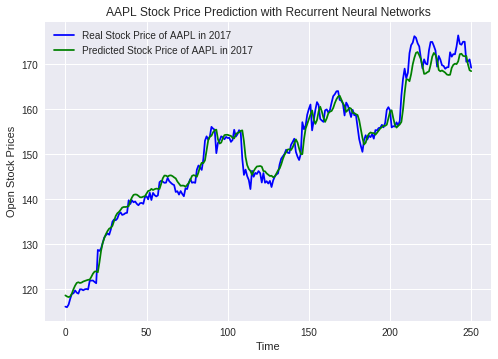

In [0]:
# Part - 3 - Making the predictions and visualising the results.
#Getting the real stock price of 2017
#Importing Training set.
dataset_test=test.iloc[:,2].values.reshape(-1,1)
#Creates the dataframe with "Open" coloumn
real_stock_prices = test.iloc[:,2].values
#Getting the predicted stock prices of 2017
dataset_total = pd.concat((train.iloc[:,2], test.iloc[:,2]), axis = 0)
#Getting the first data row that we will use for the predict the first test data.
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#We are modifying the numpy array as all the inputs in one coloumn
inputs = inputs.reshape(-1,1)
#Scaling the input with fitted scaler
inputs = sc.transform(inputs)


X_test = []
for i in range(60, (60+251)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#Reshaping for giving X_test to the RNN as an input.
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Predicting the scaled stock prices
predicted_stock_price = regressor.predict(X_test)
#Inverse scaling and transforming
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 


#Visualising the results
#Visualising the results
mse = mean_squared_error(real_stock_prices, predicted_stock_price)
print(mse)
plt.plot(real_stock_prices, color= 'b', label= 'Real Stock Price of AAPL in 2017')
plt.plot(predicted_stock_price, color= 'g', label= 'Predicted Stock Price of AAPL in 2017')
plt.title('AAPL Stock Price Prediction with Recurrent Neural Networks')
plt.xlabel('Time')
plt.ylabel('Open Stock Prices')
plt.legend()
plt.show()